In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 
import time

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#distance Libaray
from dtw import dtw
from scipy.spatial.distance import euclidean

#FFNN Libarary
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Đọc Dữ Liệu
# @param   filePath     Đường dẫn tập dữ liệu CSV
# @return  df           Tập dữ liệu csv dưới dạng df
def readData(filePath):
    # Load dữ liệu
    dataCSV = pd.read_csv(filePath)
    df=dataCSV[['Close']]
    return df

# Tiền Xử lý Dữ Liệu
# @param  Data   Tập dữ liệu
# @return df     Dữ liệu đã được tiền xử lý
def cleanData(df):
    # Replace null values with 0
    df.fillna(0, inplace=True)
    # Remove outliers by replacing values outside of 10 standard deviations with the mean
    std = df['Close'].std()
    mean = df['Close'].mean()
    df['Close'] = np.where(df['Close'] > (mean + 10*std), mean, df['Close'])
    df['Close'] = np.where(df['Close'] < (mean - 10*std), mean, df['Close'])
    # Scale data_AMZN to range [0, 1]
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    # Fill in missing values with the mean of the previous and next values
    df['Close'] = df['Close'].interpolate(method='linear')
    return df

# Chia dữ liệu thành train set và test set
# @param  data                      Tập dữ liệu
# @param  percentTrain              Tỷ lệ Tập train
# @return train_data, test_data     Tập train và test   
def splitData(data, percentTrain):
    train_size = int(len(data) * (percentTrain/100))
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    return train, test

# Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
# @param      data            Dữ liệu cần chia cửa sổ
# @param      size_window     Kích thước cửa sổ
# @param      size_predict    Kích thước cửa sổ dự đoán
# @param      stepWindow      số điểm dữ liệu trượt
# @return     X, y            mảng cửa sổ mẫu và mảng điểm dự đoán tương ứng
def prepare_data(data, size_window, size_predict, stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        startWindow += stepWindow
    return np.array(X), np.array(y)

#---------KNN-----------
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean    
def euclidean_distance(ts1, ts2):
    ts1= ts1.flatten()
    ts2= ts2.flatten()
    return euclidean(ts1,ts2)

# Function lấy ra k chuỗi gần nhất
# @param    k             Số lượng chuỗi gần nhất
# @param    distanceArr   Mảng khoảng cách
# @return   argsort       Vị trí chuỗi gần nhất        
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

# Tính khoảng cách DTW
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean  
def dtw_dist(ts1, ts2):
    dist, _, _, _ = dtw(ts1, ts2, dist=lambda ts1, ts2: np.abs(ts1 - ts2))
    return dist

# Thêm Dữ liệu
# @param    X_train               Cửa sổ mẫu train
# @param    y_train               Cửa sổ dự đoán train
# @param    XTest                 Cửa sổ mẫu test
# @param    yTest                 Cửa sổ dự đoán test
# @return   X_train, y_train      Khoảng cách euclidean 
def toTrain(X_train, y_train, XTest, yTest):
    X_train.append(XTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

# Dự đoán Euclidean
# @param    nameData           Tên tập dữ liệu
# @param    k                  Số lượng chuỗi gần nhất
# @param    typeDistance       Độ đo sử dụng (Dtw, euclidean)
# @param    X_train            Cửa sổ mẫu train
# @param    y_train            Cửa sổ dự đoán train
# @param    X_test             Cửa sổ mẫu test
# @param    y_test             Cửa sổ dự đoán test
# @return   y_pred_arr         Mảng dự đoán
def predict_KNN(k, typeDistance, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            if(typeDistance == 'Dtw'):
                distance = dtw_dist(X_test[iTest],X_train[iTrain])
            else:
                distance = euclidean_distance(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = toTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        y_pred = np.array(y_pred_arr)
   
    return y_pred


#----------------FFNN--------------------------
# Khởi tạo mô hình FFNN
# @param    neuralInput         Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    num_layers_hidden   Số lượng lớp ẩn
# @param    num_neural_hidden   Số neural lớp ẩn
# @param    neuralOutput         Số neural lớp ouput
# @return   model               Mô hình FFNN
def create_model_FFNN(neuralInput, num_layers_hidden=1, neuralHidden=1, neuralOutput=1):
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(Dense(neuralHidden, input_dim= neuralInput, activation='sigmoid'))
        else:
            model.add(Dense(neuralHidden, activation='sigmoid'))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_FFNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': [8, 16, 32, 64, 128],
              'epochs': [50, 100, 150, 200, 250, 300],
              'neuralHidden': [neuralHidden],
              'num_layers_hidden' : [numHiddenLayer],
              'neuralInput' : [size_window],
              'neuralOutput' : [size_predict]}

    # create the model
    model_FFNN = KerasRegressor(build_fn=create_model_FFNN, verbose=0)
    
    # perform the grid search
    grid_FFNN = GridSearchCV(estimator=model_FFNN, param_grid=param_grid_FFNN, cv=3)
    grid_result_FFNN = grid_FFNN.fit(X_train, y_train)
    
    # train the model with the best parameters
    best_params_FFNN = grid_result_FFNN.best_params_
    
    model_FFNN = create_model_FFNN( best_params_FFNN['neuralInput'], best_params_FFNN['num_layers_hidden'], best_params_FFNN['neuralHidden'],best_params_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=best_params_FFNN['epochs'], batch_size=best_params_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    return best_params_FFNN



# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    batchSize         Số lượng mẫu được đưa vào với mỗi lần lặp (epoch)
# @param    epoch             Số lần lặp cập nhật trọng số
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_best_param_FFNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': batchSize,
              'epochs': epoch,
              'neuralHidden': neuralHidden,
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    
    model_FFNN = create_model_FFNN( param_grid_FFNN['neuralInput'], param_grid_FFNN['num_layers_hidden'], param_grid_FFNN['neuralHidden'],param_grid_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=param_grid_FFNN['epochs'], batch_size=param_grid_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN.save_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    return param_grid_FFNN

# Dự Đoán FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    typePredict       Thực hiện loại dự đoán (FFNN_Find_NeuralHidden,FFNN_Find_NumberHiddenLayer,CombinePredict)
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    X_test            Cửa sổ dự đoán tập train
# @param    best_params_FFNN  Cửa sổ dự đoán tập train
# @return   predictions_FFNN  Mảng dự đoán
def predict_FFNN(nameData, typePredict, X_train, y_train, X_test, best_params_FFNN):
    model_FFNN1 = Sequential()
    for i in range(best_params_FFNN['num_layers_hidden']):
        if i == 0:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], input_dim= best_params_FFNN['neuralInput'], activation='sigmoid'))
        else:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], activation='sigmoid'))
    model_FFNN1.add(Dense(best_params_FFNN['neuralOutput']))
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN1.load_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN1.load_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    model_FFNN1.compile(loss='mean_squared_error', optimizer='adam')
    
    predictions_FFNN = model_FFNN1.predict(X_test)
    return predictions_FFNN

#---------------------Song Song------------------------------#

# Lai Ghép Song Song
# @param    y_pred_FFNN     Mảng dự đoán của FFNN
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   y_pred_combine  Mảng dự đoán kết hợp
def predictHybrid(y_pred_FFNN,y_pred_KNN,y_test):
    FFNNSubKNN=[]
    TestSubKNN=[]
    weightEl=[]
    for i in range(len(y_pred_FFNN)):
        FFNNSubKNN.append(y_pred_FFNN[i]-y_pred_KNN[i])
        TestSubKNN.append(y_test[i]-y_pred_KNN[i])

    for j in range(len(FFNNSubKNN)):
        weightEl.append(((FFNNSubKNN[j]*TestSubKNN[j])/ (FFNNSubKNN[j]*FFNNSubKNN[j])))
    
    weight = np.array(weightEl)
    
    y_pred_combine=[]
    for i in range(len(weight)):
        y_pred_combine.append(weight[i]*y_pred_FFNN[i]+(1-weight[i])*y_pred_KNN[i])
    y_pred_combine=np.array(y_pred_combine)
    return y_pred_combine

#---------------------Tuần Tự------------------------------#

# Tính Lỗi Theo Từng Ngày
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   mseWithDay     Mảng lỗi theo ngày
def mseWithDay(y_pred_KNN, y_test):
    mseDay = []
    for i in range(len(y_pred_KNN)):
        mseDay.append([abs((y_test[i] - y_pred_KNN[i]))])
    mseDay=np.array(mseDay)
    return mseDay

def predictSum(y_pred_mse,y_pred_KNN):
    pred_knn_ffnn=[]
    for i in range(len(y_pred_mse)):
        pred_knn_ffnn.append(y_pred_KNN[i]+y_pred_mse[i])
    pred_knn_ffnn=np.array(pred_knn_ffnn)
    return pred_knn_ffnn

In [23]:
nameData= 'MDLY'
filePath= '../../Dataset/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
percentTrain = 80
train_data, test_data = splitData(timeSeries, percentTrain)

size_window = 7
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

neuralHidden=17
batchSize=8
epoch=300
df_MseWith_HiddenLayer = pd.DataFrame([],  columns =  ["Numer Hidden Layer", "Neural Hidden","Batch_Size","Epoch", "MSE","Time Train", "Time Test", "Total Time"])

for numHiddenLayer in range(1,21):
    
    start_Train= time.time()
    best_param = train_best_param_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict)
    end_Train = time.time()
    
    start_Test= time.time()
    predictions_FFNN= predict_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)
    end_Test = time.time()

    timeTrain = end_Train - start_Train
    timeTest = end_Test -  start_Test
    totalTime = timeTrain+ timeTest
    
    rowMseWithHiddenLayer = pd.Series([numHiddenLayer,neuralHidden,best_param['batch_size'],best_param['epochs'], mean_squared_error(y_test , predictions_FFNN), timeTrain, timeTest, totalTime], index=df_MseWith_HiddenLayer.columns)
    df_MseWith_HiddenLayer = df_MseWith_HiddenLayer.append(rowMseWithHiddenLayer,ignore_index=True)   

Epoch 1/300
138/138 - 2s - loss: 0.2394 - 2s/epoch - 11ms/step
Epoch 2/300
138/138 - 0s - loss: 0.0401 - 242ms/epoch - 2ms/step
Epoch 3/300
138/138 - 0s - loss: 0.0408 - 247ms/epoch - 2ms/step
Epoch 4/300
138/138 - 0s - loss: 0.0402 - 306ms/epoch - 2ms/step
Epoch 5/300
138/138 - 0s - loss: 0.0393 - 234ms/epoch - 2ms/step
Epoch 6/300
138/138 - 0s - loss: 0.0381 - 207ms/epoch - 2ms/step
Epoch 7/300
138/138 - 0s - loss: 0.0369 - 204ms/epoch - 1ms/step
Epoch 8/300
138/138 - 0s - loss: 0.0355 - 211ms/epoch - 2ms/step
Epoch 9/300
138/138 - 0s - loss: 0.0340 - 193ms/epoch - 1ms/step
Epoch 10/300
138/138 - 0s - loss: 0.0324 - 316ms/epoch - 2ms/step
Epoch 11/300
138/138 - 0s - loss: 0.0306 - 295ms/epoch - 2ms/step
Epoch 12/300
138/138 - 0s - loss: 0.0286 - 309ms/epoch - 2ms/step
Epoch 13/300
138/138 - 0s - loss: 0.0265 - 256ms/epoch - 2ms/step
Epoch 14/300
138/138 - 0s - loss: 0.0242 - 191ms/epoch - 1ms/step
Epoch 15/300
138/138 - 0s - loss: 0.0219 - 275ms/epoch - 2ms/step
Epoch 16/300
138/138 

Epoch 121/300
138/138 - 0s - loss: 6.3218e-04 - 237ms/epoch - 2ms/step
Epoch 122/300
138/138 - 0s - loss: 6.2917e-04 - 424ms/epoch - 3ms/step
Epoch 123/300
138/138 - 0s - loss: 6.2621e-04 - 253ms/epoch - 2ms/step
Epoch 124/300
138/138 - 0s - loss: 6.2329e-04 - 404ms/epoch - 3ms/step
Epoch 125/300
138/138 - 0s - loss: 6.2043e-04 - 257ms/epoch - 2ms/step
Epoch 126/300
138/138 - 0s - loss: 6.1761e-04 - 209ms/epoch - 2ms/step
Epoch 127/300
138/138 - 0s - loss: 6.1484e-04 - 198ms/epoch - 1ms/step
Epoch 128/300
138/138 - 0s - loss: 6.1211e-04 - 216ms/epoch - 2ms/step
Epoch 129/300
138/138 - 0s - loss: 6.0943e-04 - 196ms/epoch - 1ms/step
Epoch 130/300
138/138 - 0s - loss: 6.0679e-04 - 184ms/epoch - 1ms/step
Epoch 131/300
138/138 - 0s - loss: 6.0420e-04 - 189ms/epoch - 1ms/step
Epoch 132/300
138/138 - 0s - loss: 6.0165e-04 - 187ms/epoch - 1ms/step
Epoch 133/300
138/138 - 0s - loss: 5.9914e-04 - 172ms/epoch - 1ms/step
Epoch 134/300
138/138 - 0s - loss: 5.9666e-04 - 171ms/epoch - 1ms/step
Epoch 

Epoch 237/300
138/138 - 0s - loss: 4.7370e-04 - 185ms/epoch - 1ms/step
Epoch 238/300
138/138 - 0s - loss: 4.7314e-04 - 189ms/epoch - 1ms/step
Epoch 239/300
138/138 - 0s - loss: 4.7257e-04 - 171ms/epoch - 1ms/step
Epoch 240/300
138/138 - 0s - loss: 4.7201e-04 - 173ms/epoch - 1ms/step
Epoch 241/300
138/138 - 0s - loss: 4.7145e-04 - 189ms/epoch - 1ms/step
Epoch 242/300
138/138 - 0s - loss: 4.7090e-04 - 184ms/epoch - 1ms/step
Epoch 243/300
138/138 - 0s - loss: 4.7035e-04 - 172ms/epoch - 1ms/step
Epoch 244/300
138/138 - 0s - loss: 4.6980e-04 - 186ms/epoch - 1ms/step
Epoch 245/300
138/138 - 0s - loss: 4.6926e-04 - 189ms/epoch - 1ms/step
Epoch 246/300
138/138 - 0s - loss: 4.6872e-04 - 187ms/epoch - 1ms/step
Epoch 247/300
138/138 - 0s - loss: 4.6818e-04 - 184ms/epoch - 1ms/step
Epoch 248/300
138/138 - 0s - loss: 4.6765e-04 - 189ms/epoch - 1ms/step
Epoch 249/300
138/138 - 0s - loss: 4.6712e-04 - 171ms/epoch - 1ms/step
Epoch 250/300
138/138 - 0s - loss: 4.6660e-04 - 173ms/epoch - 1ms/step
Epoch 

138/138 - 0s - loss: 0.0023 - 160ms/epoch - 1ms/step
Epoch 44/300
138/138 - 0s - loss: 0.0023 - 160ms/epoch - 1ms/step
Epoch 45/300
138/138 - 0s - loss: 0.0022 - 200ms/epoch - 1ms/step
Epoch 46/300
138/138 - 0s - loss: 0.0022 - 200ms/epoch - 1ms/step
Epoch 47/300
138/138 - 0s - loss: 0.0021 - 198ms/epoch - 1ms/step
Epoch 48/300
138/138 - 0s - loss: 0.0021 - 200ms/epoch - 1ms/step
Epoch 49/300
138/138 - 0s - loss: 0.0020 - 200ms/epoch - 1ms/step
Epoch 50/300
138/138 - 0s - loss: 0.0020 - 200ms/epoch - 1ms/step
Epoch 51/300
138/138 - 0s - loss: 0.0019 - 213ms/epoch - 2ms/step
Epoch 52/300
138/138 - 0s - loss: 0.0019 - 200ms/epoch - 1ms/step
Epoch 53/300
138/138 - 0s - loss: 0.0018 - 214ms/epoch - 2ms/step
Epoch 54/300
138/138 - 0s - loss: 0.0018 - 200ms/epoch - 1ms/step
Epoch 55/300
138/138 - 0s - loss: 0.0018 - 200ms/epoch - 1ms/step
Epoch 56/300
138/138 - 0s - loss: 0.0018 - 214ms/epoch - 2ms/step
Epoch 57/300
138/138 - 0s - loss: 0.0017 - 200ms/epoch - 1ms/step
Epoch 58/300
138/138 - 

Epoch 46/300
138/138 - 0s - loss: 0.0422 - 214ms/epoch - 2ms/step
Epoch 47/300
138/138 - 0s - loss: 0.0422 - 200ms/epoch - 1ms/step
Epoch 48/300
138/138 - 0s - loss: 0.0422 - 198ms/epoch - 1ms/step
Epoch 49/300
138/138 - 0s - loss: 0.0422 - 200ms/epoch - 1ms/step
Epoch 50/300
138/138 - 0s - loss: 0.0421 - 214ms/epoch - 2ms/step
Epoch 51/300
138/138 - 0s - loss: 0.0421 - 200ms/epoch - 1ms/step
Epoch 52/300
138/138 - 0s - loss: 0.0421 - 214ms/epoch - 2ms/step
Epoch 53/300
138/138 - 0s - loss: 0.0421 - 199ms/epoch - 1ms/step
Epoch 54/300
138/138 - 0s - loss: 0.0421 - 198ms/epoch - 1ms/step
Epoch 55/300
138/138 - 0s - loss: 0.0420 - 215ms/epoch - 2ms/step
Epoch 56/300
138/138 - 0s - loss: 0.0420 - 198ms/epoch - 1ms/step
Epoch 57/300
138/138 - 0s - loss: 0.0420 - 200ms/epoch - 1ms/step
Epoch 58/300
138/138 - 0s - loss: 0.0420 - 214ms/epoch - 2ms/step
Epoch 59/300
138/138 - 0s - loss: 0.0419 - 213ms/epoch - 2ms/step
Epoch 60/300
138/138 - 0s - loss: 0.0419 - 214ms/epoch - 2ms/step
Epoch 61/3

138/138 - 0s - loss: 0.0383 - 213ms/epoch - 2ms/step
Epoch 170/300
138/138 - 0s - loss: 0.0383 - 201ms/epoch - 1ms/step
Epoch 171/300
138/138 - 0s - loss: 0.0382 - 199ms/epoch - 1ms/step
Epoch 172/300
138/138 - 0s - loss: 0.0382 - 197ms/epoch - 1ms/step
Epoch 173/300
138/138 - 0s - loss: 0.0382 - 201ms/epoch - 1ms/step
Epoch 174/300
138/138 - 0s - loss: 0.0381 - 198ms/epoch - 1ms/step
Epoch 175/300
138/138 - 0s - loss: 0.0381 - 200ms/epoch - 1ms/step
Epoch 176/300
138/138 - 0s - loss: 0.0381 - 214ms/epoch - 2ms/step
Epoch 177/300
138/138 - 0s - loss: 0.0380 - 215ms/epoch - 2ms/step
Epoch 178/300
138/138 - 0s - loss: 0.0380 - 198ms/epoch - 1ms/step
Epoch 179/300
138/138 - 0s - loss: 0.0380 - 200ms/epoch - 1ms/step
Epoch 180/300
138/138 - 0s - loss: 0.0379 - 214ms/epoch - 2ms/step
Epoch 181/300
138/138 - 0s - loss: 0.0379 - 201ms/epoch - 1ms/step
Epoch 182/300
138/138 - 0s - loss: 0.0379 - 212ms/epoch - 2ms/step
Epoch 183/300
138/138 - 0s - loss: 0.0379 - 200ms/epoch - 1ms/step
Epoch 184

Epoch 292/300
138/138 - 0s - loss: 0.0359 - 213ms/epoch - 2ms/step
Epoch 293/300
138/138 - 0s - loss: 0.0359 - 198ms/epoch - 1ms/step
Epoch 294/300
138/138 - 0s - loss: 0.0359 - 203ms/epoch - 1ms/step
Epoch 295/300
138/138 - 0s - loss: 0.0359 - 212ms/epoch - 2ms/step
Epoch 296/300
138/138 - 0s - loss: 0.0359 - 200ms/epoch - 1ms/step
Epoch 297/300
138/138 - 0s - loss: 0.0358 - 209ms/epoch - 2ms/step
Epoch 298/300
138/138 - 0s - loss: 0.0358 - 204ms/epoch - 1ms/step
Epoch 299/300
138/138 - 0s - loss: 0.0358 - 214ms/epoch - 2ms/step
Epoch 300/300
138/138 - 0s - loss: 0.0358 - 200ms/epoch - 1ms/step
9/9 [==============================] - 0s 2ms/step
Epoch 1/300
138/138 - 2s - loss: 0.0906 - 2s/epoch - 13ms/step
Epoch 2/300
138/138 - 0s - loss: 0.0449 - 228ms/epoch - 2ms/step
Epoch 3/300
138/138 - 0s - loss: 0.0451 - 228ms/epoch - 2ms/step
Epoch 4/300
138/138 - 0s - loss: 0.0452 - 212ms/epoch - 2ms/step
Epoch 5/300
138/138 - 0s - loss: 0.0452 - 227ms/epoch - 2ms/step
Epoch 6/300
138/138 - 0

138/138 - 0s - loss: 0.0385 - 213ms/epoch - 2ms/step
Epoch 116/300
138/138 - 0s - loss: 0.0385 - 211ms/epoch - 2ms/step
Epoch 117/300
138/138 - 0s - loss: 0.0385 - 215ms/epoch - 2ms/step
Epoch 118/300
138/138 - 0s - loss: 0.0384 - 211ms/epoch - 2ms/step
Epoch 119/300
138/138 - 0s - loss: 0.0384 - 213ms/epoch - 2ms/step
Epoch 120/300
138/138 - 0s - loss: 0.0384 - 227ms/epoch - 2ms/step
Epoch 121/300
138/138 - 0s - loss: 0.0383 - 213ms/epoch - 2ms/step
Epoch 122/300
138/138 - 0s - loss: 0.0383 - 228ms/epoch - 2ms/step
Epoch 123/300
138/138 - 0s - loss: 0.0383 - 212ms/epoch - 2ms/step
Epoch 124/300
138/138 - 0s - loss: 0.0382 - 212ms/epoch - 2ms/step
Epoch 125/300
138/138 - 0s - loss: 0.0382 - 229ms/epoch - 2ms/step
Epoch 126/300
138/138 - 0s - loss: 0.0382 - 212ms/epoch - 2ms/step
Epoch 127/300
138/138 - 0s - loss: 0.0381 - 227ms/epoch - 2ms/step
Epoch 128/300
138/138 - 0s - loss: 0.0381 - 213ms/epoch - 2ms/step
Epoch 129/300
138/138 - 0s - loss: 0.0381 - 227ms/epoch - 2ms/step
Epoch 130

Epoch 238/300
138/138 - 0s - loss: 0.0359 - 227ms/epoch - 2ms/step
Epoch 239/300
138/138 - 0s - loss: 0.0359 - 213ms/epoch - 2ms/step
Epoch 240/300
138/138 - 0s - loss: 0.0359 - 227ms/epoch - 2ms/step
Epoch 241/300
138/138 - 0s - loss: 0.0358 - 213ms/epoch - 2ms/step
Epoch 242/300
138/138 - 0s - loss: 0.0358 - 213ms/epoch - 2ms/step
Epoch 243/300
138/138 - 0s - loss: 0.0358 - 227ms/epoch - 2ms/step
Epoch 244/300
138/138 - 0s - loss: 0.0358 - 213ms/epoch - 2ms/step
Epoch 245/300
138/138 - 0s - loss: 0.0358 - 227ms/epoch - 2ms/step
Epoch 246/300
138/138 - 0s - loss: 0.0358 - 213ms/epoch - 2ms/step
Epoch 247/300
138/138 - 0s - loss: 0.0358 - 213ms/epoch - 2ms/step
Epoch 248/300
138/138 - 0s - loss: 0.0358 - 225ms/epoch - 2ms/step
Epoch 249/300
138/138 - 0s - loss: 0.0358 - 228ms/epoch - 2ms/step
Epoch 250/300
138/138 - 0s - loss: 0.0357 - 211ms/epoch - 2ms/step
Epoch 251/300
138/138 - 0s - loss: 0.0357 - 231ms/epoch - 2ms/step
Epoch 252/300
138/138 - 0s - loss: 0.0357 - 223ms/epoch - 2ms/

Epoch 49/300
138/138 - 0s - loss: 0.0404 - 227ms/epoch - 2ms/step
Epoch 50/300
138/138 - 0s - loss: 0.0403 - 227ms/epoch - 2ms/step
Epoch 51/300
138/138 - 0s - loss: 0.0403 - 242ms/epoch - 2ms/step
Epoch 52/300
138/138 - 0s - loss: 0.0402 - 227ms/epoch - 2ms/step
Epoch 53/300
138/138 - 0s - loss: 0.0401 - 225ms/epoch - 2ms/step
Epoch 54/300
138/138 - 0s - loss: 0.0401 - 227ms/epoch - 2ms/step
Epoch 55/300
138/138 - 0s - loss: 0.0400 - 227ms/epoch - 2ms/step
Epoch 56/300
138/138 - 0s - loss: 0.0399 - 226ms/epoch - 2ms/step
Epoch 57/300
138/138 - 0s - loss: 0.0399 - 238ms/epoch - 2ms/step
Epoch 58/300
138/138 - 0s - loss: 0.0398 - 229ms/epoch - 2ms/step
Epoch 59/300
138/138 - 0s - loss: 0.0398 - 227ms/epoch - 2ms/step
Epoch 60/300
138/138 - 0s - loss: 0.0397 - 227ms/epoch - 2ms/step
Epoch 61/300
138/138 - 0s - loss: 0.0397 - 225ms/epoch - 2ms/step
Epoch 62/300
138/138 - 0s - loss: 0.0396 - 227ms/epoch - 2ms/step
Epoch 63/300
138/138 - 0s - loss: 0.0395 - 227ms/epoch - 2ms/step
Epoch 64/3

138/138 - 0s - loss: 0.0361 - 273ms/epoch - 2ms/step
Epoch 173/300
138/138 - 0s - loss: 0.0361 - 218ms/epoch - 2ms/step
Epoch 174/300
138/138 - 0s - loss: 0.0361 - 242ms/epoch - 2ms/step
Epoch 175/300
138/138 - 0s - loss: 0.0360 - 227ms/epoch - 2ms/step
Epoch 176/300
138/138 - 0s - loss: 0.0360 - 240ms/epoch - 2ms/step
Epoch 177/300
138/138 - 0s - loss: 0.0360 - 258ms/epoch - 2ms/step
Epoch 178/300
138/138 - 0s - loss: 0.0360 - 234ms/epoch - 2ms/step
Epoch 179/300
138/138 - 0s - loss: 0.0360 - 229ms/epoch - 2ms/step
Epoch 180/300
138/138 - 0s - loss: 0.0360 - 240ms/epoch - 2ms/step
Epoch 181/300
138/138 - 0s - loss: 0.0359 - 226ms/epoch - 2ms/step
Epoch 182/300
138/138 - 0s - loss: 0.0359 - 240ms/epoch - 2ms/step
Epoch 183/300
138/138 - 0s - loss: 0.0359 - 224ms/epoch - 2ms/step
Epoch 184/300
138/138 - 0s - loss: 0.0359 - 241ms/epoch - 2ms/step
Epoch 185/300
138/138 - 0s - loss: 0.0359 - 233ms/epoch - 2ms/step
Epoch 186/300
138/138 - 0s - loss: 0.0358 - 279ms/epoch - 2ms/step
Epoch 187

Epoch 295/300
138/138 - 0s - loss: 0.0346 - 232ms/epoch - 2ms/step
Epoch 296/300
138/138 - 0s - loss: 0.0346 - 228ms/epoch - 2ms/step
Epoch 297/300
138/138 - 0s - loss: 0.0346 - 239ms/epoch - 2ms/step
Epoch 298/300
138/138 - 0s - loss: 0.0346 - 229ms/epoch - 2ms/step
Epoch 299/300
138/138 - 0s - loss: 0.0346 - 226ms/epoch - 2ms/step
Epoch 300/300
138/138 - 0s - loss: 0.0345 - 225ms/epoch - 2ms/step
9/9 [==============================] - 0s 2ms/step
Epoch 1/300
138/138 - 2s - loss: 0.0813 - 2s/epoch - 16ms/step
Epoch 2/300
138/138 - 0s - loss: 0.0452 - 240ms/epoch - 2ms/step
Epoch 3/300
138/138 - 0s - loss: 0.0451 - 256ms/epoch - 2ms/step
Epoch 4/300
138/138 - 0s - loss: 0.0451 - 240ms/epoch - 2ms/step
Epoch 5/300
138/138 - 0s - loss: 0.0451 - 254ms/epoch - 2ms/step
Epoch 6/300
138/138 - 0s - loss: 0.0452 - 240ms/epoch - 2ms/step
Epoch 7/300
138/138 - 0s - loss: 0.0452 - 239ms/epoch - 2ms/step
Epoch 8/300
138/138 - 0s - loss: 0.0452 - 240ms/epoch - 2ms/step
Epoch 9/300
138/138 - 0s - lo

138/138 - 0s - loss: 0.0400 - 254ms/epoch - 2ms/step
Epoch 119/300
138/138 - 0s - loss: 0.0399 - 242ms/epoch - 2ms/step
Epoch 120/300
138/138 - 0s - loss: 0.0399 - 240ms/epoch - 2ms/step
Epoch 121/300
138/138 - 0s - loss: 0.0398 - 238ms/epoch - 2ms/step
Epoch 122/300
138/138 - 0s - loss: 0.0398 - 240ms/epoch - 2ms/step
Epoch 123/300
138/138 - 0s - loss: 0.0397 - 256ms/epoch - 2ms/step
Epoch 124/300
138/138 - 0s - loss: 0.0397 - 237ms/epoch - 2ms/step
Epoch 125/300
138/138 - 0s - loss: 0.0396 - 238ms/epoch - 2ms/step
Epoch 126/300
138/138 - 0s - loss: 0.0396 - 228ms/epoch - 2ms/step
Epoch 127/300
138/138 - 0s - loss: 0.0395 - 239ms/epoch - 2ms/step
Epoch 128/300
138/138 - 0s - loss: 0.0395 - 238ms/epoch - 2ms/step
Epoch 129/300
138/138 - 0s - loss: 0.0394 - 240ms/epoch - 2ms/step
Epoch 130/300
138/138 - 0s - loss: 0.0394 - 238ms/epoch - 2ms/step
Epoch 131/300
138/138 - 0s - loss: 0.0393 - 242ms/epoch - 2ms/step
Epoch 132/300
138/138 - 0s - loss: 0.0393 - 240ms/epoch - 2ms/step
Epoch 133

Epoch 241/300
138/138 - 0s - loss: 0.0360 - 239ms/epoch - 2ms/step
Epoch 242/300
138/138 - 0s - loss: 0.0359 - 239ms/epoch - 2ms/step
Epoch 243/300
138/138 - 0s - loss: 0.0359 - 240ms/epoch - 2ms/step
Epoch 244/300
138/138 - 0s - loss: 0.0359 - 240ms/epoch - 2ms/step
Epoch 245/300
138/138 - 0s - loss: 0.0359 - 240ms/epoch - 2ms/step
Epoch 246/300
138/138 - 0s - loss: 0.0359 - 240ms/epoch - 2ms/step
Epoch 247/300
138/138 - 0s - loss: 0.0358 - 238ms/epoch - 2ms/step
Epoch 248/300
138/138 - 0s - loss: 0.0358 - 241ms/epoch - 2ms/step
Epoch 249/300
138/138 - 0s - loss: 0.0358 - 239ms/epoch - 2ms/step
Epoch 250/300
138/138 - 0s - loss: 0.0358 - 240ms/epoch - 2ms/step
Epoch 251/300
138/138 - 0s - loss: 0.0358 - 238ms/epoch - 2ms/step
Epoch 252/300
138/138 - 0s - loss: 0.0357 - 240ms/epoch - 2ms/step
Epoch 253/300
138/138 - 0s - loss: 0.0357 - 241ms/epoch - 2ms/step
Epoch 254/300
138/138 - 0s - loss: 0.0357 - 255ms/epoch - 2ms/step
Epoch 255/300
138/138 - 0s - loss: 0.0357 - 240ms/epoch - 2ms/

138/138 - 0s - loss: 0.0452 - 280ms/epoch - 2ms/step
Epoch 14/300
138/138 - 0s - loss: 0.0453 - 266ms/epoch - 2ms/step
Epoch 15/300
138/138 - 0s - loss: 0.0453 - 342ms/epoch - 2ms/step
Epoch 16/300
138/138 - 0s - loss: 0.0453 - 300ms/epoch - 2ms/step
9/9 [==============================] - 0s 4ms/step
Epoch 1/300
138/138 - 3s - loss: 0.1450 - 3s/epoch - 24ms/step
Epoch 2/300
138/138 - 0s - loss: 0.0435 - 322ms/epoch - 2ms/step
Epoch 3/300
138/138 - 0s - loss: 0.0445 - 273ms/epoch - 2ms/step
Epoch 4/300
138/138 - 0s - loss: 0.0449 - 280ms/epoch - 2ms/step
Epoch 5/300
138/138 - 0s - loss: 0.0449 - 282ms/epoch - 2ms/step
Epoch 6/300
138/138 - 0s - loss: 0.0449 - 280ms/epoch - 2ms/step
Epoch 7/300
138/138 - 0s - loss: 0.0449 - 278ms/epoch - 2ms/step
Epoch 8/300
138/138 - 0s - loss: 0.0448 - 267ms/epoch - 2ms/step
Epoch 9/300
138/138 - 0s - loss: 0.0447 - 282ms/epoch - 2ms/step
Epoch 10/300
138/138 - 0s - loss: 0.0446 - 280ms/epoch - 2ms/step
Epoch 11/300
138/138 - 0s - loss: 0.0445 - 280ms/

In [24]:
df_MseWith_HiddenLayer

,Numer Hidden Layer,Neural Hidden,Batch_Size,Epoch,MSE,Time Train,Time Test,Total Time
0,1.0,17.0,8.0,300.0,0.000053,58.732235,0.199588,58.931823
1,2.0,17.0,8.0,300.0,0.000401,11.901498,0.238217,12.139715
2,3.0,17.0,8.0,300.0,0.000150,61.914838,0.207903,62.122741
3,4.0,17.0,8.0,300.0,0.012003,4.402402,0.230565,4.632967
4,5.0,17.0,8.0,300.0,0.003132,16.142950,0.257780,16.400729
5,6.0,17.0,8.0,300.0,0.014398,4.954020,0.300262,5.254282
6,7.0,17.0,8.0,300.0,0.013524,4.134980,0.376472,4.511452
7,8.0,17.0,8.0,300.0,0.012652,5.977040,0.329512,6.306551
8,9.0,17.0,8.0,300.0,0.014452,5.125425,0.456413,5.581837
9,10.0,17.0,8.0,300.0,0.058525,66.295928,0.266703,66.562631


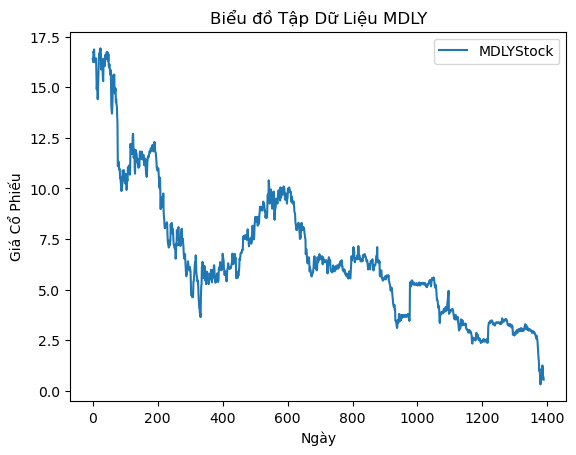

In [25]:
plt.title("Biểu đồ Tập Dữ Liệu "+nameData)
plt.plot(readData(filePath), label= nameData+'Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()


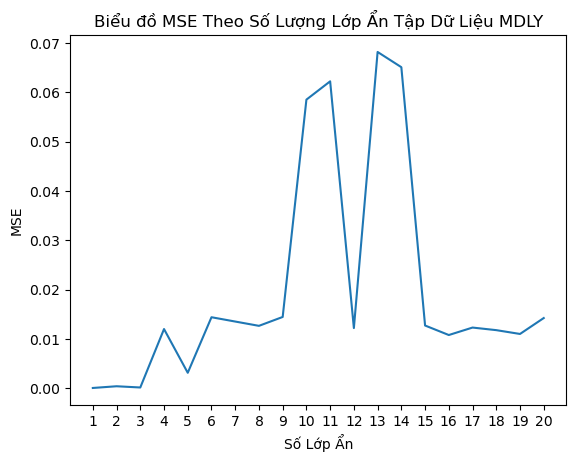

In [26]:
# Vẽ biểu đồ
plt.plot(range(1,len(df_MseWith_HiddenLayer[['MSE']])+1), df_MseWith_HiddenLayer[['MSE']])
plt.title("Biểu đồ MSE Theo Số Lượng Lớp Ẩn Tập Dữ Liệu "+nameData)
plt.xlabel("Số Lớp Ẩn")
plt.ylabel("MSE")
plt.xticks(range(1,len(df_MseWith_HiddenLayer[['MSE']])+1))
plt.show()

In [27]:
df_MseWith_HiddenLayer_Sort = df_MseWith_HiddenLayer.sort_values('MSE')
best_NumberHiddenLayer=df_MseWith_HiddenLayer_Sort['Numer Hidden Layer'].iloc[0]

In [28]:
df_MseWith_HiddenLayer_Sort

,Numer Hidden Layer,Neural Hidden,Batch_Size,Epoch,MSE,Time Train,Time Test,Total Time
0,1.0,17.0,8.0,300.0,0.000053,58.732235,0.199588,58.931823
2,3.0,17.0,8.0,300.0,0.000150,61.914838,0.207903,62.122741
1,2.0,17.0,8.0,300.0,0.000401,11.901498,0.238217,12.139715
4,5.0,17.0,8.0,300.0,0.003132,16.142950,0.257780,16.400729
15,16.0,17.0,8.0,300.0,0.010791,5.518989,0.355122,5.874110
18,19.0,17.0,8.0,300.0,0.011006,7.481052,0.521319,8.002371
17,18.0,17.0,8.0,300.0,0.011779,6.535331,0.378796,6.914127
3,4.0,17.0,8.0,300.0,0.012003,4.402402,0.230565,4.632967
11,12.0,17.0,8.0,300.0,0.012203,4.400235,0.295805,4.696040
16,17.0,17.0,8.0,300.0,0.012303,5.461719,0.382328,5.844047


In [29]:
best_NumberHiddenLayer

1.0

9/9 [==============================] - 0s 2ms/step


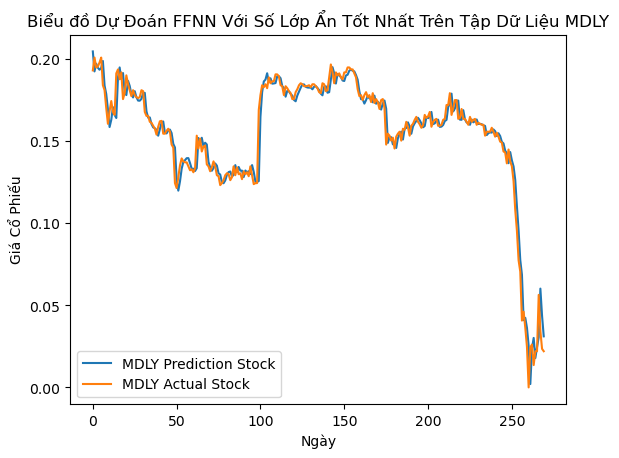

In [30]:
# Vẽ biểu đồ
best_param = {'batch_size': int(df_MseWith_HiddenLayer_Sort['Batch_Size'].iloc[0]),
              'epochs': int(df_MseWith_HiddenLayer_Sort['Epoch'].iloc[0]),
              'neuralHidden': int(df_MseWith_HiddenLayer_Sort['Neural Hidden'].iloc[0]),
              'num_layers_hidden' :int(df_MseWith_HiddenLayer_Sort['Numer Hidden Layer'].iloc[0]),
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
y_pred= predict_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)

plt.title("Biểu đồ Dự Đoán FFNN Với Số Lớp Ẩn Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()

In [35]:
print("MSE: " + str(mean_squared_error(y_test , y_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, y_pred)) ))
print("MAE: " + str(mean_absolute_error(y_test,y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred)))

MSE: 5.345068852233224e-05
RMSE: 0.007310997778848811
MAE: 0.004643256633421447
MAPE: 423807078551.7528


# Load Predict

In [31]:
# neural=17
# batch_size=8
# epochs=300

# nameData= 'MDLY'
# filePath= '../../Dataset/'+nameData+'.csv'
# timeSeries = readData(filePath)
# timeSeries = cleanData(timeSeries)
# percentTrain = 80
# train_data, test_data = splitData(timeSeries, percentTrain)

# size_window = 7
# size_predict=1
# stepWindow=1
# X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
# X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

# numHiddenLayer= range(1,21)

# df_MseWith_HiddenLayer = pd.DataFrame([],  columns =  ["Number Hidden Layer","Neural Hidden","Batch_Size","Epoch", "MSE"])

# for i in range(len(numHiddenLayer)):

#     best_param = {'batch_size': batch_size,
#               'epochs': epochs,
#               'neuralHidden': neural,
#               'num_layers_hidden' : numHiddenLayer[i],
#               'neuralInput' : size_window,
#               'neuralOutput' : size_predict}
#     y_pred= predict_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)
#     rowMseWithHiddenLayer = pd.Series([numHiddenLayer[i],neural,batch_size,epochs, mean_squared_error(y_test , y_pred)], index=df_MseWith_HiddenLayer.columns)
#     df_MseWith_HiddenLayer = df_MseWith_HiddenLayer.append(rowMseWithHiddenLayer,ignore_index=True)
# df_MseWith_HiddenLayer_Sort = df_MseWith_HiddenLayer.sort_values('MSE')
# best_Neural=df_MseWith_HiddenLayer_Sort['Number Hidden Layer'].iloc[0]

9/9 [==============================] - 0s 2ms/step


Thay thế các giá trị null bằng 0 .

Loại bỏ các giá trị nhiễu bằng cách thay thế các giá trị nằm ngoài khoảng 3 độ lệch chuẩn của dữ liệu với giá trị trung bình của dữ liệu.

MinMaxScaler để chuyển đổi dữ liệu thành phạm vi [0, 1]. Tiếp theo, chúng ta sử dụng 

Interpolate để điền vào các giá trị bị thiếu bằng cách lấy trung bình của các giá trị trước và sau đó.


std() là một hàm trong Python để tính độ lệch chuẩn của một tập dữ liệu. 

Công thức tính độ lệch chuẩn của một tập dữ liệu là:
σ = sqrt(1/n * Σ(xi - x_mean)^2)

Ví dụ, nếu chúng ta có tập dữ liệu [2, 4, 6, 8], thì giá trị trung bình là 5, độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [-3, -1, 1, 3], giá trị bình phương độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [9, 1, 1, 9], đưa vào công thức độ lệch chuẩn
 ==> σ = sqrt(1/4 * (9 + 1 + 1 + 9)) = sqrt(20/4) = sqrt(5) ≈ 2.236

